In [1]:
import psycopg2
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
conn = psycopg2.connect(
    host="158.160.110.228",
    port=5432,
    database="postgres",
    user="student",
    password="JvLda93aA",
)

cursor = conn.cursor()

In [3]:
X_LABEL = 'Интервал'
Y_LABEL_CNT = 'Количество клиентов'
Y_LABEL_RATE = 'Доля клиентов'

INTERVALS = ['month', 'week']

### Считаем воронки по месяцам

In [4]:
def generate_funnel_query(interval):
    return f"""
        with stats as (
            SELECT
                DATE_TRUNC('{interval}', c.visit_dttm) AS {interval},
                COUNT(DISTINCT c.client_rk) AS visitors,
                COUNT(DISTINCT a.client_rk) AS registrations,
                COUNT(DISTINCT app.account_rk) AS applications,
                COUNT(DISTINCT CASE WHEN g.game_flg = 1 THEN app.account_rk END) AS attended
            FROM
                msu_analytics.client c
                LEFT JOIN msu_analytics.account a ON c.client_rk = a.client_rk
                LEFT JOIN msu_analytics.application app ON a.account_rk = app.account_rk
                LEFT JOIN msu_analytics.game g ON app.game_rk = g.game_rk
                GROUP BY {interval}
        )
        select
            {interval},
            registrations::DECIMAL / NULLIF(visitors, 0) as reg_vis_rate,
            applications::DECIMAL / NULLIF(registrations, 0) as app_reg_rate,
            attended::DECIMAL / NULLIF(applications, 0) as att_app_rate
        from stats
        ORDER BY {interval};
        """

In [5]:
funnels = {}

for interval in INTERVALS:
    cursor.execute(generate_funnel_query(interval))
    funnels[interval] = cursor.fetchall()

In [6]:
def plot_funnels_rates(data, interval):
    columns = [interval, "type", "rate"]
    types = ['reg_vis_rate', 'app_reg_rate', 'att_app_rate']
    
    df_data = []

    for row in data[interval]:
        for idx, value in enumerate(row[1:]):
            df_data.append((row[0], types[idx], value))

    df = pd.DataFrame(df_data, columns=columns)

    df[interval] = df[interval].dt.strftime("%y-%m-%d")

    _ = sns.catplot(
        data=df,
        kind="bar",
        x=interval,
        y="rate",
        hue="type",
        palette="dark",
        alpha=0.6,
        height=6,
    )

    plt.xticks(rotation=60)
    plt.show()

### Тут используется $seaborn$

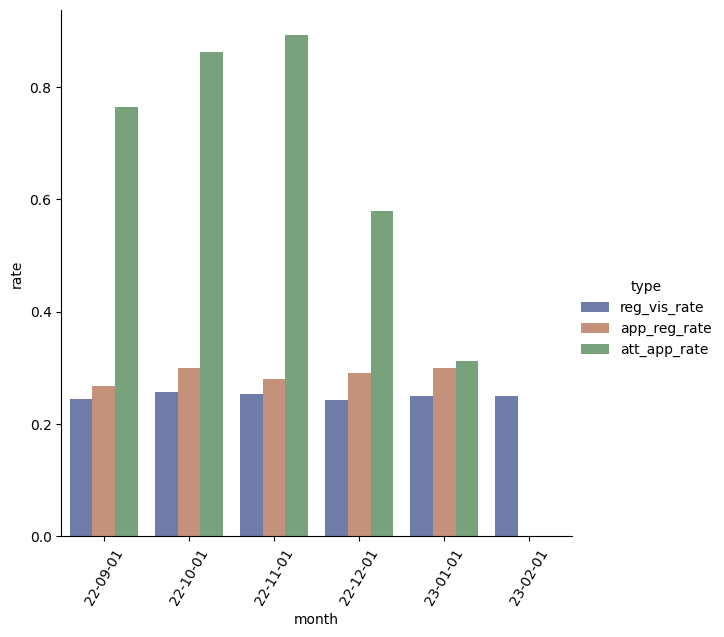

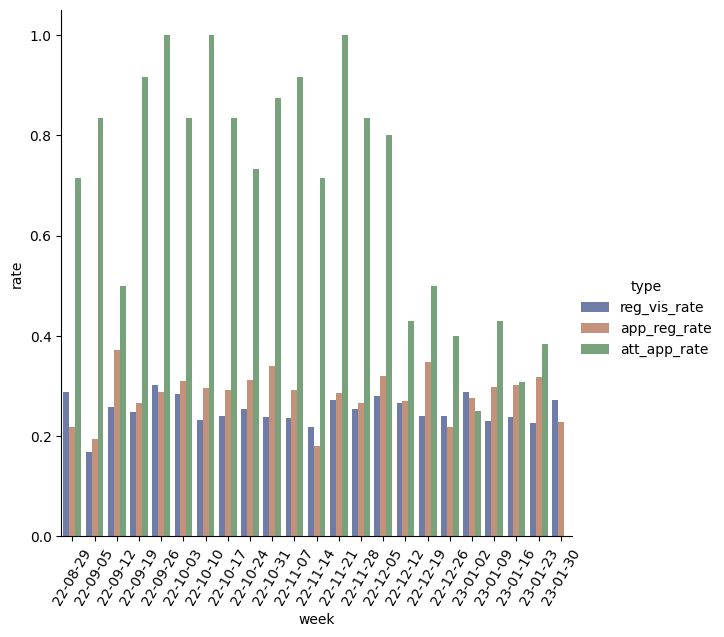

In [7]:
for interval in INTERVALS:
    plot_funnels_rates(funnels, interval)

### Собираем данные по посещениям

In [8]:
def generate_visits_query(interval):
    return f"""
        SELECT
            DATE_TRUNC('{interval}', visit_dttm) AS {interval},
            COUNT(DISTINCT client_rk) AS visitors
        FROM msu_analytics.client
        GROUP BY {interval}
        ORDER BY {interval};
        """

In [9]:
visits = {}

for interval in INTERVALS:
    cursor.execute(generate_visits_query(interval))
    visits[interval] = cursor.fetchall()

In [10]:
def plot_visits(raw_data, interval):
    dates = [row[0] for row in raw_data]
    counts = [row[1] for row in raw_data]
    
    plt.title(f'Динамика посещений сайта ({interval})')
    plt.xlabel(X_LABEL)
    plt.ylabel(Y_LABEL_CNT)
    
    plt.plot(dates, counts)
    
    plt.show()

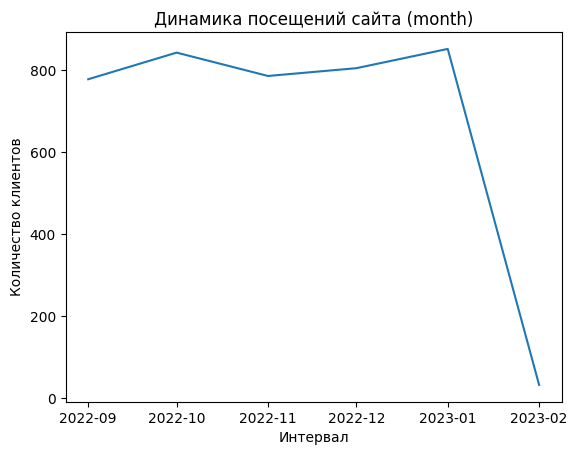

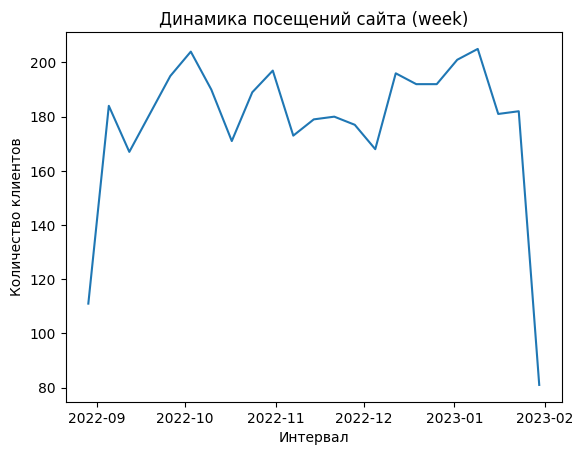

In [11]:
for interval, data in visits.items():
    plot_visits(data, interval)

In [12]:
def generate_rates_query(interval):
    return f"""
        SELECT
            DATE_TRUNC('{interval}', c.visit_dttm) AS {interval},
            COUNT(DISTINCT c.client_rk) AS visitors,
            COUNT(DISTINCT a.client_rk) AS registrations,
            COUNT(DISTINCT app.account_rk) AS applications,
            COUNT(DISTINCT CASE WHEN g.game_flg = 1 THEN app.account_rk END) AS attended
        FROM
            msu_analytics.client c
            LEFT JOIN msu_analytics.account a ON c.client_rk = a.client_rk
            LEFT JOIN msu_analytics.application app ON a.account_rk = app.account_rk
            LEFT JOIN msu_analytics.game g ON app.game_rk = g.game_rk
        GROUP BY {interval}
        ORDER BY {interval};
        """

In [13]:
rates = {}

In [14]:
for interval in INTERVALS:
    cursor.execute(generate_rates_query(interval))
    rates[interval] = cursor.fetchall()

In [15]:
def plot_rates(data, interval):
    columns = [interval, 'visitors', 'registrations', 'applications', 'attended']
    
    df_data = {}
    
    for idx, column in enumerate(columns):
        df_data[column] = [row[idx] for row in data]
    
    df = pd.DataFrame(df_data)

    df[interval] = pd.to_datetime(df[interval])

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(df[interval], df['visitors'], width=6, label='Посетители', color='lightblue')
    ax.bar(df[interval], df['registrations'], width=6, label='Регистрации', color='orange')
    ax.bar(df[interval], df['applications'], width=6, label='Заявки на квест', color='lightgreen')
    ax.bar(df[interval], df['attended'], width=6, label='Посетившие квест', color='red')

    ax.set_title(f'Динамика посещений по целевым группам ({interval})')
    ax.set_xlabel(X_LABEL)
    ax.set_ylabel(Y_LABEL_CNT)
    ax.legend()

    plt.xticks(rotation=45)
    plt.show()

### А тут используется $matplotlib$

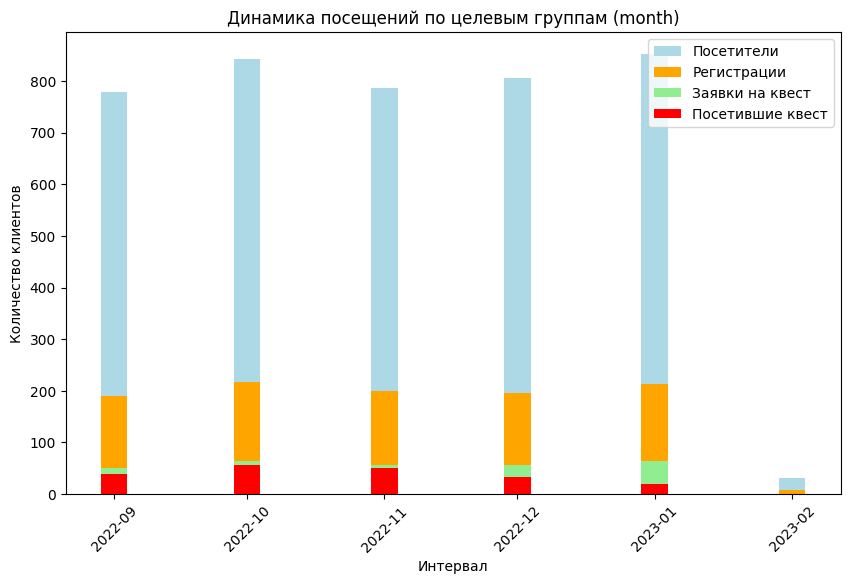

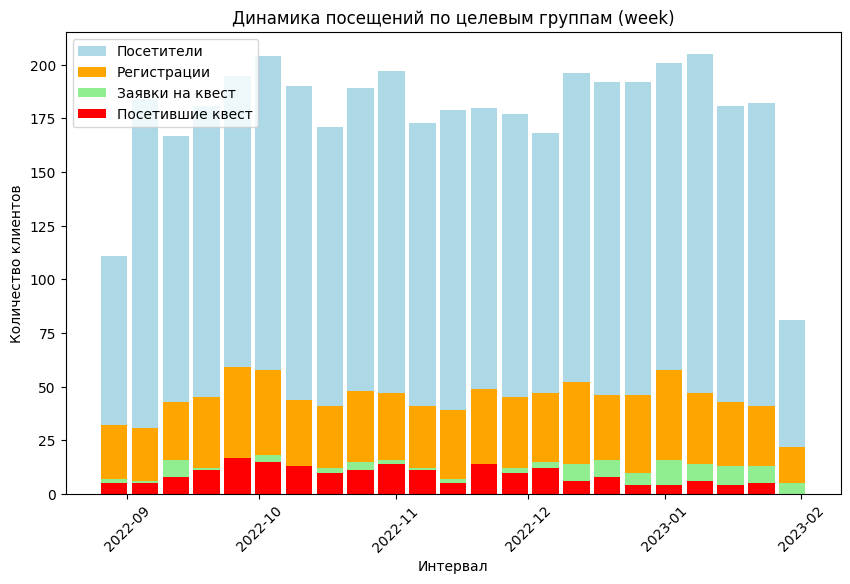

In [16]:
for interval in INTERVALS:
    plot_rates(rates[interval], interval)

P.S. условие немного расплывчатое, поэтому не стал строить на одном графике сразу <br>
но есличто это можно сделать используя:
```python
fig, ax = plt.subplots()

ax2 = ax.twinx()
```

## ВЫВОДЫ:
Глобально количество посетителей, регистраций и заявок не изменяется, ближе <br> к концу проседают посещения квестов (как в абсолютах, так и в отношении)


## ТОЧКИ РОСТА:
Возможно после заявок на квесты стоит добавить напоминалку людям / какой-либо <br> стимул посетить (например бонус после посещения)